In [1]:
%matplotlib inline
from __future__ import print_function
import os
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle as rect
import matplotlib.pyplot as plt
import platform
if 'window' in platform.platform().lower():
    pref = ''
else:
    pref= './'

## Monte Carlo with Freyberg Model

Adapted from the examples provided with `pyemu`


## Using `pyemu`

In [2]:
import pyemu
import shutil, os

basedir = os.path.join('..','..','models','Freyberg','Freyberg_pilotpoints')
[shutil.copy2(os.path.join(basedir,cf),cf) for cf in os.listdir(basedir)];
    

setting random seed


In [3]:
# get the list of forecast names from the pest++ argument in the pest control file
jco_file = 'freyberg_pp.jcb'
pst_file = 'freyberg_pp.pst'
pst = pyemu.Pst(pst_file)

In [4]:
mc = pyemu.MonteCarlo(pst=pst_file,verbose=False)

## Drawing from the prior
Each ``MonteCarlo`` instance has a ``parensemble`` attribute which itself is an instance of ``Ensemble`` class, which is derived from ``pandas.DataFrame``.  What all that means is that the parameter ensembles behave just like ```DataFrame```s

### ```draw```
The ``draw`` method is the main entry point into getting realizations. It accepts several optional arguments.  Without any args, it makes a single draw from the prior, which uses a $\boldsymbol{\mu}$ (mean) vector of the parameter values listed in the pest control file:


In [5]:
mc.draw()
print(mc.parensemble.shape)

(1, 72)


``draw`` also accepts a ``num_reals`` argument to specify the number of draws to make:

In [6]:
mc.draw(num_reals=200)
print(mc.parensemble.shape)
print(mc.parensemble.mean().head())

(200, 72)
parnme
rch1      0.000112
rch2      0.000094
hkpp1    12.410987
hkpp2    14.039465
hkpp3    11.850868
dtype: float64


## plotting

Since ```ParameterEnsemble``` is dervied from ```pandas.DataFrame```, it has all the cool methods and attributes we all love.  Let's compare the results of drawing from a uniform vs a gaussian distribution.  This may take some time.

In [7]:
mc.parensemble.columns

Index(['rch1', 'rch2', 'hkpp1', 'hkpp2', 'hkpp3', 'hkpp4', 'hkpp5', 'hkpp6',
       'hkpp7', 'hkpp8', 'hkpp9', 'hkpp10', 'hkpp11', 'hkpp12', 'hkpp13',
       'hkpp14', 'hkpp15', 'hkpp16', 'hkpp17', 'hkpp18', 'hkpp19', 'hkpp20',
       'hkpp21', 'hkpp22', 'hkpp23', 'hkpp24', 'hkpp25', 'hkpp26', 'hkpp27',
       'hkpp28', 'hkpp29', 'hkpp30', 'hkpp31', 'hkpp32', 'hkpp33', 'hkpp34',
       'hkpp35', 'hkpp36', 'hkpp37', 'hkpp38', 'hkpp39', 'hkpp40', 'hkpp41',
       'hkpp42', 'hkpp43', 'hkpp44', 'hkpp45', 'hkpp46', 'hkpp47', 'hkpp48',
       'hkpp49', 'hkpp50', 'hkpp51', 'hkpp52', 'hkpp53', 'hkpp54', 'hkpp55',
       'hkpp56', 'hkpp57', 'hkpp58', 'hkpp59', 'hkpp60', 'hkpp61', 'hkpp62',
       'hkpp63', 'hkpp64', 'hkpp65', 'hkpp66', 'hkpp67', 'hkpp68', 'hkpp69',
       'hkpp70'],
      dtype='object', name='parnme')

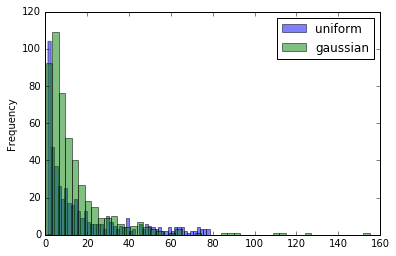

In [8]:
mc.draw(num_reals=500,how="uniform")
ax = plt.subplot(111)
partoplot = 'hkpp10'
mc.parensemble.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5)
mc.draw(num_reals=500,how="gaussian")
mc.parensemble.loc[:,partoplot].plot(kind="hist",bins=50,ax=ax,alpha=0.5)
plt.legend(['uniform','gaussian'])

In [9]:
def plot_first_10_reals(paren):
    arrs = []
    pp_df = pyemu.utils.gw_utils.pp_file_to_dataframe("points1.dat")
    pp_df.loc[:,"iidx"] = pp_df.index
    for i in range(10):    
        pp_df.index = pp_df.name
        pp_df.loc[:,"parval1"] = paren.iloc[i,:].T
        pp_df.index = pp_df.iidx
        arr = pyemu.utils.gw_utils.fac2real(pp_df,"factors1.dat")
        arrs.append(np.log10(np.loadtxt(arr)))
    mx,mn = -1.0E+10,1.0e+10
    for arr in arrs:
        mx = max(mx,arr.max())
        mn = min(mn,arr.min())
    fig = plt.figure(figsize=(10,10))
    for i,arr in enumerate(arrs):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(arr,vmax=mx,vmin=mn,interpolation="nearest")
    plt.show()
    
    

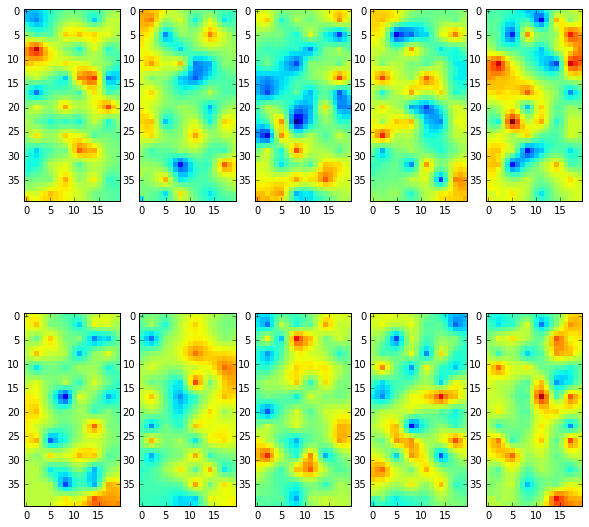

In [10]:
plot_first_10_reals(mc.parensemble)

Do these look "right" (from a geologic stand point)?

Let's use a full covariance matrix and see how that looks

,hkpp1,hkpp2,hkpp3,hkpp4,hkpp5,hkpp6,hkpp7,hkpp8,hkpp9,hkpp10,...,hkpp62,hkpp63,hkpp64,hkpp65,hkpp66,hkpp67,hkpp68,hkpp69,hkpp70,rch1
hkpp1,0.220000,0.107065,0.039520,0.002755,0.000000,0.000000,0.107065,0.076340,0.027494,0.000738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hkpp2,0.107065,0.220000,0.107065,0.039520,0.002755,0.000000,0.076340,0.107065,0.076340,0.027494,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hkpp3,0.039520,0.107065,0.220000,0.107065,0.039520,0.002755,0.027494,0.076340,0.107065,0.076340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hkpp4,0.002755,0.039520,0.107065,0.220000,0.107065,0.039520,0.000738,0.027494,0.076340,0.107065,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hkpp5,0.000000,0.002755,0.039520,0.107065,0.220000,0.107065,0.000000,0.000738,0.027494,0.076340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


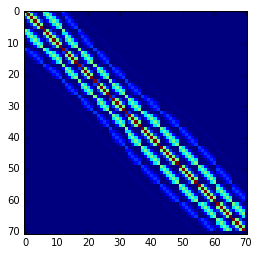

In [11]:
rch_names = [pname for pname in mc.pst.adj_par_names if "rch" in pname]
parcov_rch = mc.parcov.get(row_names=rch_names)
gs = pyemu.utils.geostats.read_struct_file("structure.dat")
#gs.variograms[0].a=10000
#gs.variograms[0].contribution=0.01
#gs.variograms[0].anisotropy = 10.0
pp_df = pyemu.utils.gw_utils.pp_file_to_dataframe("points1.dat")
parcov_hk = gs.covariance_matrix(pp_df.x,pp_df.y,pp_df.name)
parcov_full = parcov_hk.extend(parcov_rch)
plt.imshow(parcov_full.x,interpolation="nearest")
parcov_full.to_dataframe().head()

In [12]:
mc_full = pyemu.MonteCarlo(pst=pst_file,parcov=parcov_full)

In [13]:
mc_full.draw(100)

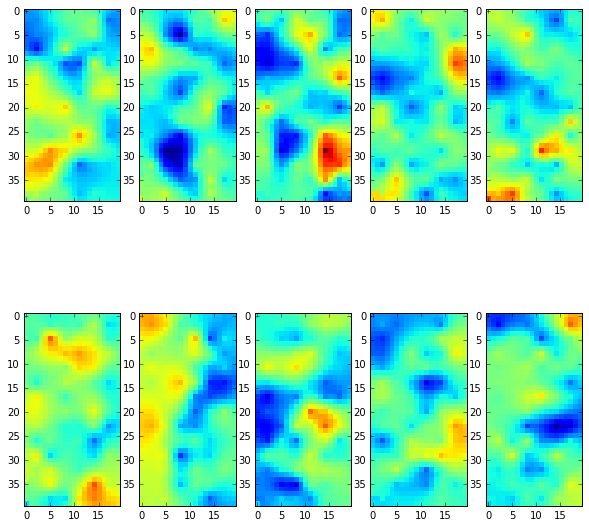

In [14]:
plot_first_10_reals(mc_full.parensemble)

In [46]:
mc_full.draw(100)

In [47]:
mc_full.parensemble.to_csv("sweep_in.csv")

In [48]:
pyemu.helpers.start_slaves(basedir,"{0}sweep".format(pref),pst_file,num_slaves=10,master_dir='.')

In [49]:
df_out = pd.read_csv("sweep_out.csv",index_col=0)
df_out = df_out.loc[df_out.failed_flag==0,:] #drop an failed runs
df_out.head()

,failed_flag,phi,meas_phi,regul_phi,FLUX_CAL,HEAD_FORE,FLUX_FORE,TRAVEL_FORE,HEAD_CAL,CR03C16,...,FR27C7,FR30C16,FR34C8,FR35C11,FR02C02,FR01C13,FR09C15,FR25C10,RIVFLUX_FORE,TRAVEL_TIME
run_id,,,,,,,,,,,,,,,,,,,,,
0,0,62.509366,62.509366,0,2.267253,0,0,0,60.242113,19.50881,...,18.24115,14.34195,17.66468,14.56732,29.40394,20.75465,1.797671e+01,17.26829,-2743.303,27499.930
1,0,603.404228,603.404228,0,493.769730,0,0,0,109.634498,19.49732,...,17.49746,13.23666,15.61862,12.53024,26.14066,20.19824,1.750677e+01,16.12426,-1452.210,11757.270
2,0,152.213335,152.213335,0,92.278118,0,0,0,59.935217,19.65328,...,19.38107,14.36057,17.32196,13.30753,30.11526,20.52018,1.669880e+01,18.05135,-2243.171,37205.020
3,0,103.250349,103.250349,0,21.051029,0,0,0,82.199320,20.94002,...,19.08384,14.19523,15.03560,13.53785,25.00251,21.37307,-9.999999e+06,17.24732,-2914.419,4876.281
4,0,544.996544,544.996544,0,366.618714,0,0,0,178.377829,19.49844,...,16.67840,13.83332,15.33651,13.82401,23.57973,20.09087,1.755005e+01,15.88157,-1646.858,17568.230
